# Machine learning pipeline for modelling fraction of precipitation in different intensity bands

This notebook is designed to be run in AzureML 

### Import relevant libraries

In [1]:
import pathlib
import os
import datetime
import json

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# %load_ext tensorboard

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv1D, concatenate
from tensorflow.keras.layers import ZeroPadding1D, Reshape, Input, Dropout, PReLU
from tensorflow.keras.models import Sequential, Model

In [5]:
import prd_pipeline

In [6]:
pathlib.Path.cwd().parent

PosixPath('/mnt/batch/tasks/shared/LS_root/mounts/clusters/prd-ml/code/Users/hannah.brown/precip_rediagnosis')

Set up MLops for experiment tracking in AzureML

In [7]:
import mlflow
mlflow.tensorflow.autolog()

In [8]:
import azureml.core
from azureml.core import Workspace, Datastore, Dataset
from azureml.core import Experiment

prd_ws = Workspace.from_config()

In [9]:
mlflow.set_tracking_uri(prd_ws.get_mlflow_tracking_uri())

### Load and preprocess data

In [10]:
prd_prefix = 'prd'
merged_prefix = prd_prefix + '_merged'
csv_file_suffix = 'csv'

In [11]:
target_parameter = [
    'radar_fraction_in_band_instant_0.0',
    'radar_fraction_in_band_instant_0.25',
    'radar_fraction_in_band_instant_2.5',
    'radar_fraction_in_band_instant_7.0',
    'radar_fraction_in_band_instant_10.0'
]
profile_features = ['air_temperature', 'relative_humidity', 'wind_speed', 'wind_from_direction'] #'air_pressure','cloud_volume_fraction',
single_lvl_features = [] #['surface_altitude']#,'air_pressure_at_sea_level','cloud_area_fraction']#'thickness_of_rainfall_amount']#] 

In [12]:
feature_dict = {
    'profile': profile_features,
    'single_level': single_lvl_features,
    'target': target_parameter,
} 

In [13]:
load_all = False

In [14]:
if load_all:
    prd_azml_dataset_name = 'prd_merged_all_events_files'
else:
    prd_azml_dataset_name = 'prd_merged_202110_nswws_amber_oct_files'


In [15]:
prd_azml_dataset = azureml.core.Dataset.get_by_name(prd_ws, name=prd_azml_dataset_name)

In [16]:
with prd_azml_dataset.mount() as prd_mount:
    print('loading all data')
    prd_path_list = [p1 for p1 in pathlib.Path(prd_mount.mount_point).rglob('*csv') ]
    merged_df = pd.concat([pd.read_csv(p1) for p1 in prd_path_list])

Not mounting as a volume: ArgumentError(InvalidArgument { argument: "arguments.path", expected: "Glob patterns inside the path are not supported by the volume mount.Path must be a direct path to the file or folder, or end with '/**' or '/**/*' to match the entire content of the volume.", actual: "REDACTED" }). 
Falling back to dataflow mount.
loading all data
Failure while loading azureml_run_type_providers. Failed to load entrypoint automl = azureml.train.automl.run:AutoMLRun._from_run_dto with exception (azureml-core 1.42.0.post1 (/anaconda/envs/azureml_py38/lib/python3.8/site-packages), Requirement.parse('azureml-core~=1.40.0')).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.PipelineRun = azureml.pipeline.core.run:PipelineRun._from_dto with exception (azureml-core 1.42.0.post1 (/anaconda/envs/azureml_py38/lib/python3.8/site-packages), Requirement.parse('azureml-core~=1.40.0')).
Failure while loading azureml_run_type_providers. Failed to load ent

<b>TO DO:</b> Add MOGREPS-G probability in intensity bands calculation 

### Calculate u and v wind fields and add column to dataset <i>- to be moved into data prep </i>

Adding columns with u and v wind fields

In [17]:
import math

wdir_columns = prd_pipeline.get_profile_columns(['wind_from_direction'], merged_df.columns)
ws_columns = prd_pipeline.get_profile_columns(['wind_speed'], merged_df.columns)

for (wdir, ws) in zip(wdir_columns, ws_columns):
    height_level = wdir.split('_')[-1]
    print(height_level)
    merged_df[f'u_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
        lambda x: math.sin(math.radians(270 - x))) * merged_df[f'wind_speed_{height_level}']
    merged_df[f'v_wind_{height_level}'] = merged_df[f'wind_from_direction_{height_level}'].apply(
        lambda x: math.cos(math.radians(270 - x))) * merged_df[f'wind_speed_{height_level}']

5.0
10.0
20.0
30.0
50.0
75.0
100.0
150.0
200.0
250.0
300.0
400.0
500.0
600.0
700.0
800.0
1000.0
1250.0
1500.0
1750.0
2000.0
2250.0
2500.0
2750.0
3000.0
3250.0
3500.0
3750.0
4000.0
4500.0
5000.0
5500.0
6000.0


To check the u and v wind conversion, we convert back from u and v wind fields to wind speed and direction and compare this to wind speed and direction in the dataset. This test currently fails as there are a few data points with wind speeds of zero. May be worth some investigation into whether these zero are spurious or not, but perhaps easiest at this stage to filter out zero values. 

In [18]:
# test for u and v wind conversion
for (wdir, ws) in zip(wdir_columns, ws_columns):
    height_level = wdir.split('_')[-1]
    print(height_level)
    print(merged_df[(merged_df[f'wind_from_direction_{height_level}'] != np.round(np.rad2deg(np.arctan2(merged_df[f'v_wind_{height_level}'], merged_df[f'u_wind_{height_level}'])) + 180, 4))][[f'wind_from_direction_{height_level}', f'wind_speed_{height_level}']])
    merged_df = merged_df[merged_df[ws] != 0]
    
    assert (merged_df[f'wind_speed_{height_level}'] == np.round(np.sqrt(merged_df[f'u_wind_{height_level}']**2 + merged_df[f'v_wind_{height_level}']**2),4)).all()
    assert (merged_df[f'wind_from_direction_{height_level}'] == np.round(np.rad2deg(np.arctan2(merged_df[f'v_wind_{height_level}'], merged_df[f'u_wind_{height_level}'])) + 180, 4)).all()

5.0
Empty DataFrame
Columns: [wind_from_direction_5.0, wind_speed_5.0]
Index: []
10.0
Empty DataFrame
Columns: [wind_from_direction_10.0, wind_speed_10.0]
Index: []
20.0
Empty DataFrame
Columns: [wind_from_direction_20.0, wind_speed_20.0]
Index: []
30.0
Empty DataFrame
Columns: [wind_from_direction_30.0, wind_speed_30.0]
Index: []
50.0
Empty DataFrame
Columns: [wind_from_direction_50.0, wind_speed_50.0]
Index: []
75.0
Empty DataFrame
Columns: [wind_from_direction_75.0, wind_speed_75.0]
Index: []
100.0
Empty DataFrame
Columns: [wind_from_direction_100.0, wind_speed_100.0]
Index: []
150.0
Empty DataFrame
Columns: [wind_from_direction_150.0, wind_speed_150.0]
Index: []
200.0
Empty DataFrame
Columns: [wind_from_direction_200.0, wind_speed_200.0]
Index: []
250.0
Empty DataFrame
Columns: [wind_from_direction_250.0, wind_speed_250.0]
Index: []
300.0
Empty DataFrame
Columns: [wind_from_direction_300.0, wind_speed_300.0]
Index: []
400.0
Empty DataFrame
Columns: [wind_from_direction_400.0, wind_

### Data pre-processing

Split train, test and validate datasets

In [19]:
test_fraction=0.2
df_train, df_test = prd_pipeline.random_time_space_sample(merged_df, test_fraction=test_fraction, random_state=np.random.RandomState(), sampling_columns = ['time', 'latitude', 'longitude'])
data_splits, data_dims_dict = prd_pipeline.preprocess_data(df_train, feature_dict, test_fraction=test_fraction/(1-test_fraction))

target has dims: 5
dropping smallest bin: radar_fraction_in_band_instant_0.0
getting profile columns
{'nprof_features': 4, 'nheights': 33, 'nsinglvl_features': 0, 'nbands': 5}


In [20]:
data_splits['X_train'].shape

(51998, 33, 4)

### Plot pie charts of average fractions in bands

Make a copy of the training dataset and add a column which contains the label for the intensity band with the highest fraction

In [21]:
tmp = data_splits['y_train'].copy().reset_index(drop=True)
tmp['max_bin'] = tmp.idxmax(axis=1)
tmp[tmp['max_bin']==feature_dict['target'][-1]]

,radar_fraction_in_band_instant_0.0,radar_fraction_in_band_instant_0.25,radar_fraction_in_band_instant_2.5,radar_fraction_in_band_instant_7.0,radar_fraction_in_band_instant_10.0,max_bin
900,0.0,0.0,0.000000,0.330952,0.671429,radar_fraction_in_band_instant_10.0
901,0.0,0.0,0.000000,0.330952,0.671429,radar_fraction_in_band_instant_10.0
902,0.0,0.0,0.000000,0.330952,0.671429,radar_fraction_in_band_instant_10.0
903,0.0,0.0,0.000000,0.330952,0.671429,radar_fraction_in_band_instant_10.0
904,0.0,0.0,0.000000,0.330952,0.671429,radar_fraction_in_band_instant_10.0
...,...,...,...,...,...,...
28901,0.0,0.0,0.009524,0.359524,0.630952,radar_fraction_in_band_instant_10.0
28902,0.0,0.0,0.009524,0.359524,0.630952,radar_fraction_in_band_instant_10.0
28903,0.0,0.0,0.009524,0.359524,0.630952,radar_fraction_in_band_instant_10.0
28904,0.0,0.0,0.009524,0.359524,0.630952,radar_fraction_in_band_instant_10.0


Plot a pie chart of counts of the different intensity bands having highest fraction

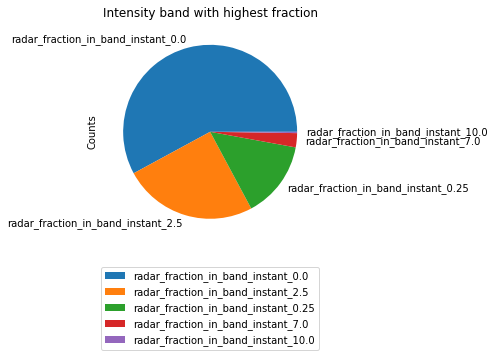

In [22]:
avg_df = pd.DataFrame({'Counts': tmp['max_bin'].value_counts()})
avg_df.plot.pie(subplots=True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.1))
plt.title('Intensity band with highest fraction')
plt.show()

In [23]:
def pie_chart_mean_fractions_in_bands(df, title):
    """Calculates the average values of a pandas series provided and produces a pie chart"""
    avg_df = pd.DataFrame({'Average': df.mean()})
    avg_df.plot.pie(subplots=True)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.1))
    plt.title(title)
    plt.show()

Produce pie chart for the average fraction in each intensity band for the train, test and validate datasets

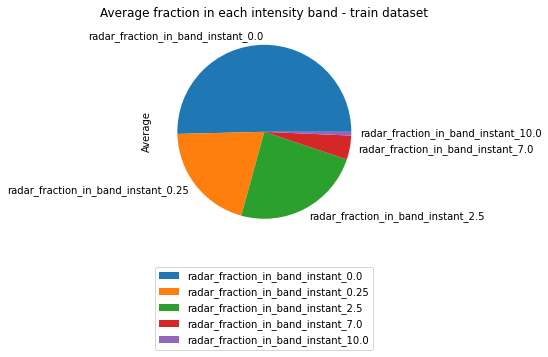

In [24]:
pie_chart_mean_fractions_in_bands(data_splits['y_train'], title='Average fraction in each intensity band - train dataset')

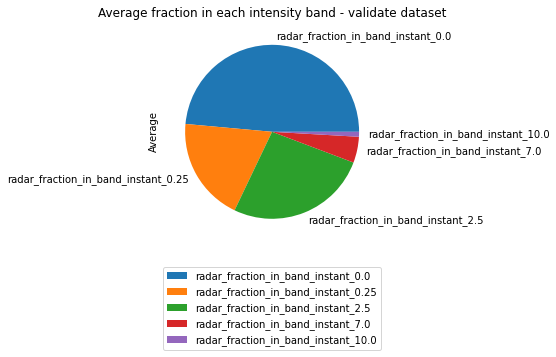

In [25]:
pie_chart_mean_fractions_in_bands(data_splits['y_val'], title='Average fraction in each intensity band - validate dataset')

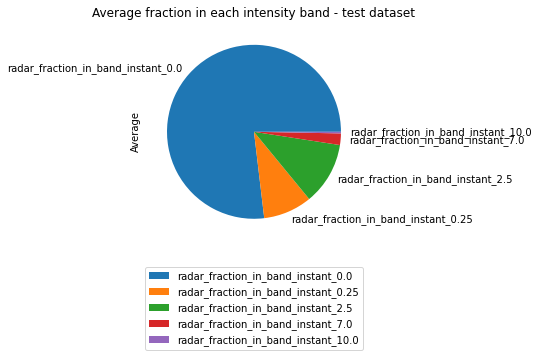

In [26]:
pie_chart_mean_fractions_in_bands(df_test[target_parameter], title='Average fraction in each intensity band - test dataset')

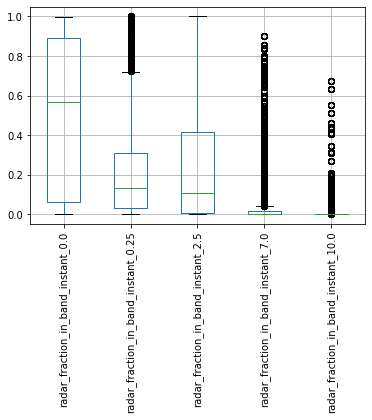

In [27]:
data_splits['y_train'].boxplot(rot=90)

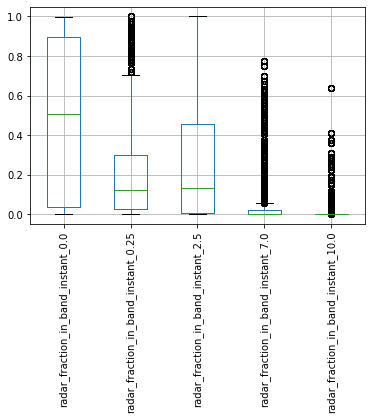

In [28]:
data_splits['y_val'].boxplot(rot=90)

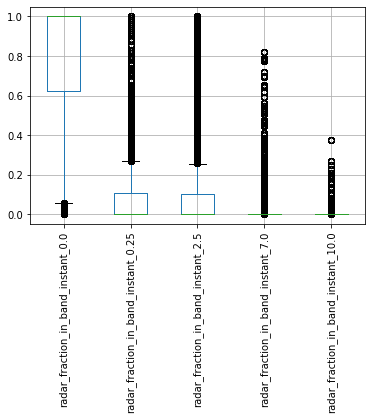

In [29]:
df_test[target_parameter].boxplot(rot=90)

For each intensity band, select a subset which contains datapoint where the highest fraction falls into that intensity band, then produce the pie chart showing this average fraction in each intensity band. This allows us to see whether on average when a band has highest fraction whether it is marginally highest or is much higher than fractions of other bands.

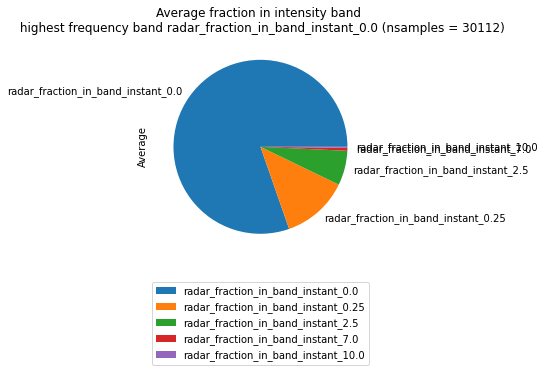

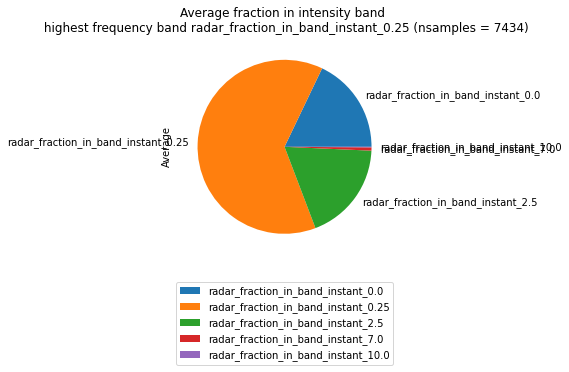

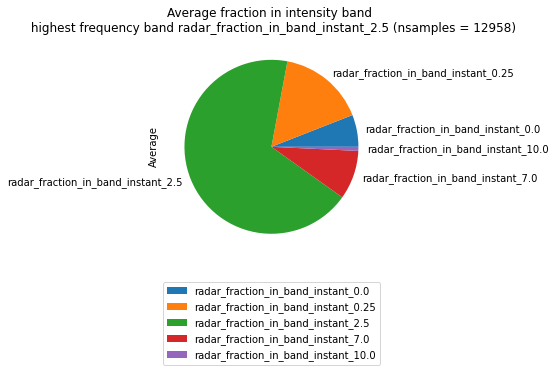

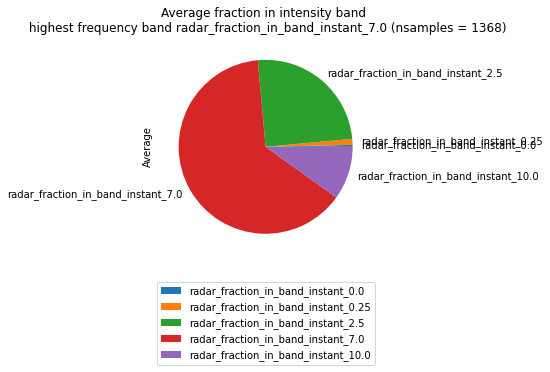

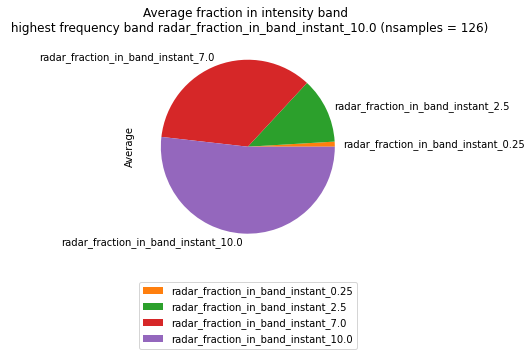

In [30]:
tmp = tmp.reset_index(drop=True)
for col in tmp.columns[:-1]:
    subset = tmp[tmp['max_bin']==col]
    pie_chart_mean_fractions_in_bands(subset, title=f'Average fraction in intensity band \n highest frequency band {col} (nsamples = {len(subset)})')
    plt.show()

### Class imbalance

Calculate weights to input when fitting model, which is used for weighting the loss function in the model training.

In [31]:
tmp = data_splits['y_train'].copy()
tmp['max_bin'] = tmp.idxmax(axis=1)

In [32]:
tmp['max_bin'].value_counts()

radar_fraction_in_band_instant_0.0     30112
radar_fraction_in_band_instant_2.5     12958
radar_fraction_in_band_instant_0.25     7434
radar_fraction_in_band_instant_7.0      1368
radar_fraction_in_band_instant_10.0      126
Name: max_bin, dtype: int64

In [33]:
data_splits['y_train'][data_splits['y_train']['radar_fraction_in_band_instant_7.0']>0.1]

,radar_fraction_in_band_instant_0.0,radar_fraction_in_band_instant_0.25,radar_fraction_in_band_instant_2.5,radar_fraction_in_band_instant_7.0,radar_fraction_in_band_instant_10.0
90,0.00000,0.000000,0.741784,0.260563,0.007042
91,0.00000,0.000000,0.741784,0.260563,0.007042
92,0.00000,0.000000,0.741784,0.260563,0.007042
93,0.00000,0.000000,0.741784,0.260563,0.007042
94,0.00000,0.000000,0.741784,0.260563,0.007042
...,...,...,...,...,...
69165,0.15407,0.098837,0.418605,0.313953,0.017442
69166,0.15407,0.098837,0.418605,0.313953,0.017442
69167,0.15407,0.098837,0.418605,0.313953,0.017442
69168,0.15407,0.098837,0.418605,0.313953,0.017442


In [34]:
data_splits['y_train'].mean()

radar_fraction_in_band_instant_0.0     0.507640
radar_fraction_in_band_instant_0.25    0.204819
radar_fraction_in_band_instant_2.5     0.243048
radar_fraction_in_band_instant_7.0     0.044802
radar_fraction_in_band_instant_10.0    0.007020
dtype: float64

In [35]:
# weights = 1 / (tmp['max_bin'].value_counts() / tmp.shape[0]) / 4
weights = 1 / data_splits['y_train'].mean() / 10
weights = weights.reset_index(drop=True).to_dict()
weights

{0: 0.19698992176237723,
 1: 0.48823576038519556,
 2: 0.4114421351576742,
 3: 2.2320524120755314,
 4: 14.24508042545655}

Resample data to create more uniform distribution within the training data

In [36]:
# nsamples = len(tmp)//len(tmp.columns)
# print('n samples =', nsamples)

# y_train = pd.DataFrame()

# tmp = tmp.reset_index(drop=True)

# for col in tmp.columns[0:-1]:
#     print(col)
#     ids = tmp[tmp['max_bin']==col].index
#     print(ids.shape)
#     if len(ids)>0:
#         choices = np.random.choice(ids, nsamples)
#         y_train = pd.concat([y_train, tmp.loc[choices]])
#         try: 
#             X_train = np.concatenate([X_train, data_splits['X_train'][choices]])
#         except NameError:
#             X_train = data_splits['X_train'][choices]

# cols = data_splits['y_train'].columns
# plt.plot(data_splits['y_train'].sum(axis=0), label='original data')
# plt.plot(y_train[cols].sum(axis=0), label='resampled data')
# plt.legend()
# plt.show()

# y_train = y_train.drop(columns=['max_bin'])

# data_splits['X_train'] = X_train
# data_splits['y_train'] = y_train
# data_dims_dict['nbands'] = data_splits['y_train'].shape[1]

## Run experiment

Here we actually run the training and evaluation. All parameters and the output model will be saved through ML Flow, and we can track training stats through tensorboard.

In [37]:
exp_name='prd_fraction_models_mlflow'
exp1 = mlflow.create_experiment(exp_name)
exp1

'27014deb-848c-4241-966e-55b80a0c8ed4'

In [38]:
exp1 = mlflow.get_experiment(exp1)
exp1

<Experiment: artifact_location='', experiment_id='27014deb-848c-4241-966e-55b80a0c8ed4', lifecycle_stage='active', name='prd_fraction_models_mlflow', tags={}>

In [43]:
hyperparameter_dict = {
    'epochs': 10, 
    'learning_rate': 0.001, 
    'batch_size': 64, 
    'class_weights': weights, 
    'loss': tf.keras.losses.KLDivergence()
}

In [44]:
with mlflow.start_run(experiment_id=exp1.experiment_id) as current_run:
    mlflow.log_param('features', feature_dict['profile'] + feature_dict['single_level'])    
    model = prd_pipeline.build_model(**data_dims_dict)
    model.summary()
    model, history = prd_pipeline.train_model(model, data_splits, hyperparameter_dict, log_dir='./logs')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
profile_input (InputLayer)      [(None, 33, 4)]      0                                            
__________________________________________________________________________________________________
zero_padding1d_6 (ZeroPadding1D (None, 35, 4)        0           profile_input[0][0]              
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 33, 32)       384         zero_padding1d_6[0][0]           
__________________________________________________________________________________________________
zero_padding1d_7 (ZeroPadding1D (None, 35, 32)       0           conv1d_6[0][0]                   
____________________________________________________________________________________________

Using TensorFlow backend.
2022/10/10 14:20:14 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: module 'tensorflow.compat.v2' has no attribute '__internal__'


### Feature importance

Here we calculate the Breiman permutation importance for each of the model input features. This allows us to assess how much information each input feature is contributing to the resulting predictions from the ML model. 

 - At each step, only one predictor is permuted (randomized)
 - The amount by which the loss function increases when 𝑥 is randomized, is considered the importance of 𝑥
 - If the loss function increases slightly when 𝑥 is permuted, 𝑥 is somewhat important
 - If the loss function explodes when 𝑥 is permuted, 𝑥 is very important
 - If the loss function remains the same or decreases when 𝑥 is permuted, 𝑥 is not important

In [45]:
feature_names = feature_dict['profile'] + feature_dict['single_level']

In [46]:
# permute by shuffling data
permutation_importance = {key:[] for key in feature_names}
npermutations = 5

original_metric = history.history['val_loss'][-1]

for ifeature, feature in enumerate(feature_names):
    print(f'permuting feature: {feature}')
    for iperm in np.arange(npermutations):
        if data_dims_dict['nsinglvl_features'] > 0:
            X_val_permute = [data_splits['X_val'][0].copy(), data_splits['X_val'][1].copy()]
            if feature in feature_dict['single_level']:
                X_val_permute[1][feature] = X_val_permute[1][feature].reindex(
                    np.random.permutation(X_val_permute[1][feature].index)).values
            else:
                X_val_permute[0][..., ifeature] = np.take(
                    X_val_permute[0][..., ifeature],
                    indices=np.random.permutation(X_val_permute[0].shape[0]),
                    axis=0)
                
        else:
            X_val_permute = data_splits['X_val'].copy()
            X_val_permute[..., ifeature] = np.take(
                X_val_permute[..., ifeature],
                indices=np.random.permutation(X_val_permute.shape[0]),
                axis=0)

        y_pred = model.predict(X_val_permute)
        
        permuted_metric = tf.keras.metrics.KLDivergence()
        permuted_metric.update_state(data_splits['y_val'], y_pred)
        permuted_metric = permuted_metric.result().numpy()
        
        permutation_importance[feature].append(permuted_metric - original_metric)

permuting feature: air_temperature
permuting feature: relative_humidity
permuting feature: wind_speed
permuting feature: wind_from_direction


In [47]:
avg_importance = {}
for k,v in permutation_importance.items():
    avg_importance[k] = np.mean(v)
print(avg_importance)

{'air_temperature': 0.3088924288749695, 'relative_humidity': 0.3082741856575012, 'wind_speed': 0.18528529405593872, 'wind_from_direction': 0.18884438276290894}


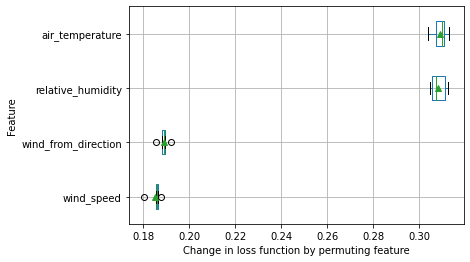

In [48]:
df = pd.DataFrame(permutation_importance)
df = df.reindex(columns=[k for k, v in sorted(avg_importance.items(), key=lambda item: item[1])])
df.boxplot(showmeans=True, vert=False)
plt.ylabel('Feature')
plt.xlabel('Change in loss function by permuting feature')
plt.show()

### Model evaluation

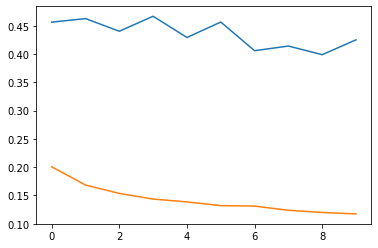

In [51]:
plt.plot(range(10),history.history['val_loss'])
plt.plot(range(10), history.history['loss'])

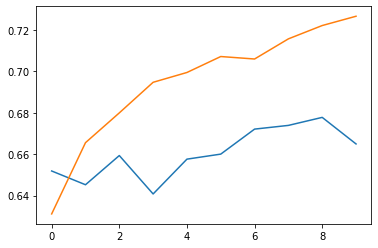

In [52]:
plt.plot(range(10), history.history['val_accuracy'])
plt.plot(range(10), history.history['accuracy'])

In [53]:
y_pred = model.predict(data_splits['X_val'])

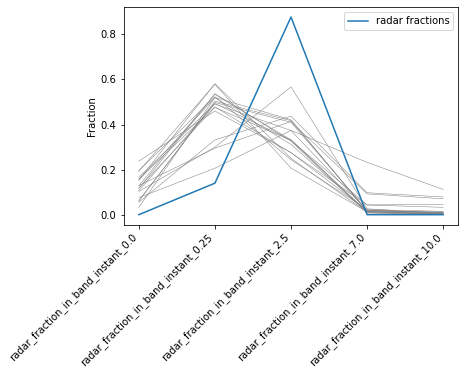

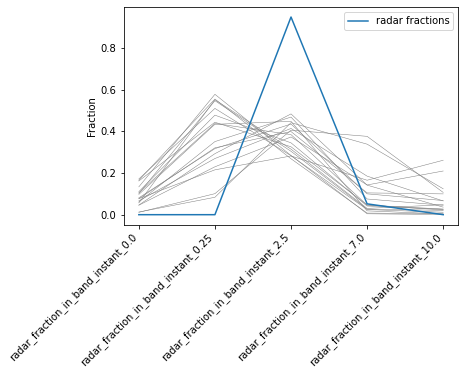

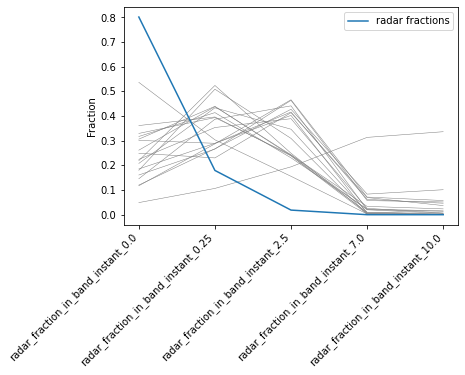

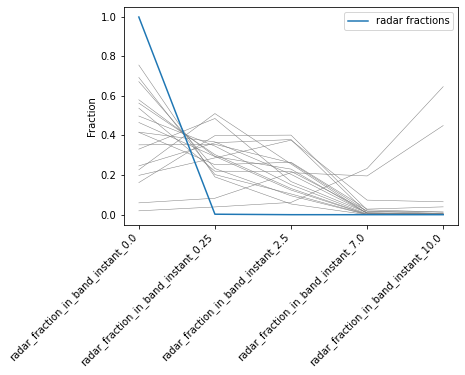

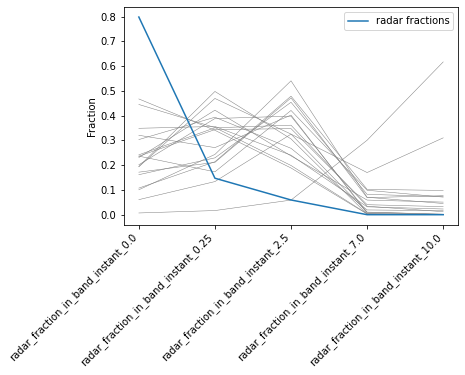

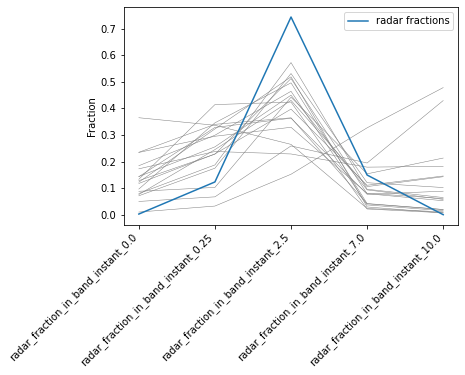

In [54]:
for loc in np.arange(0,91,18):
    for member in np.arange(18):
        plt.plot(y_pred[loc+member], lw=0.5, color='grey')
    plt.plot(data_splits['y_val'].iloc[loc+member], label='radar fractions')
    plt.ylabel('Fraction')
    plt.legend()
    plt.xticks(rotation=45, ha='right')
    plt.show()

<ipython-input-55-9cb0dc1befba>:12: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks(x, target_parameter)


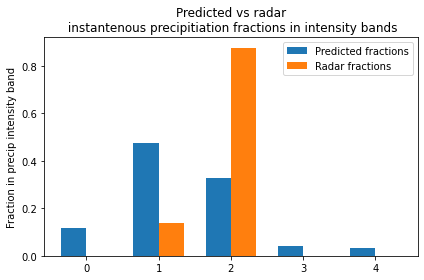

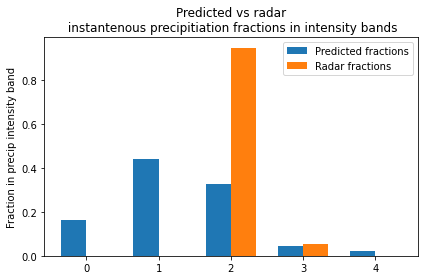

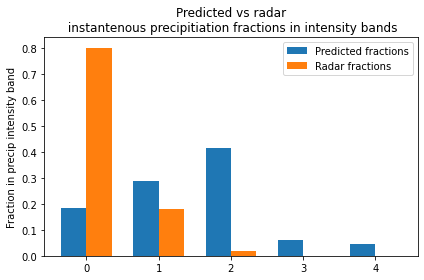

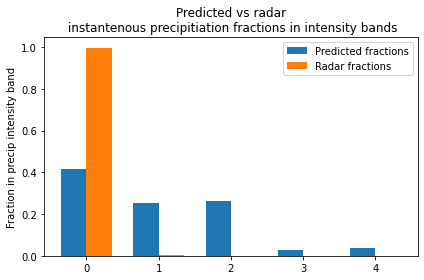

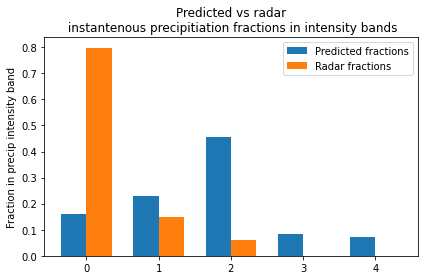

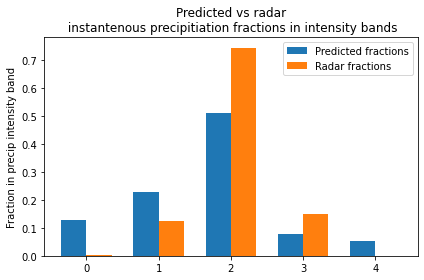

In [55]:
for loc in np.arange(0,91,18):
    x = np.arange(len(target_parameter))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, y_pred[loc], width, label='Predicted fractions')
    rects2 = ax.bar(x + width/2, data_splits['y_val'].iloc[loc], width, label='Radar fractions')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Fraction in precip intensity band')
    ax.set_title('Predicted vs radar\n instantenous precipitiation fractions in intensity bands')
    ax.set_xticks(x, target_parameter)
    ax.legend()

    fig.tight_layout()

    plt.show()
    # plt.bar(y_pred[loc], label='prediction')
    # plt.bar(data_splits['y_val'].iloc[loc], label='target')
    # plt.legend()
    # plt.show()

Fractional skill score

In [56]:
# non-cumulative i.e. assessing the FSS of specific bands individually
for i, col in enumerate(target_parameter):
    FBS = (y_pred[:,i] - data_splits['y_val'][col])**2
    FBS_ref = y_pred[:,i]**2 + data_splits['y_val'][col]**2
    FSS = np.mean(1 - (FBS/FBS_ref))
    print(f'The FSS for predicting {col}mm/hh is {FSS}')

The FSS for predicting radar_fraction_in_band_instant_0.0mm/hh is 0.6226227687056152
The FSS for predicting radar_fraction_in_band_instant_0.25mm/hh is 0.5940592411017583
The FSS for predicting radar_fraction_in_band_instant_2.5mm/hh is 0.5436902036793583
The FSS for predicting radar_fraction_in_band_instant_7.0mm/hh is 0.22191226277870882
The FSS for predicting radar_fraction_in_band_instant_10.0mm/hh is 0.05854330079637406


In [63]:
# cumulative
for i, col in enumerate(target_parameter):
    FBS = (y_pred[:,:i+1].sum(axis=1) - data_splits['y_val'][cols[:i+1]].sum(axis=1))**2
    FBS_ref = y_pred[:,:i+1].sum(axis=1)**2 + data_splits['y_val'][cols[:i+1]].sum(axis=1)**2
    FSS = np.mean(1 - (FBS/FBS_ref))
    print(f'The FSS for predicting cumulative probabilty of exceeding intensity band ({col}) maxima is {FSS}')

The FSS for predicting probabilty of exceeding intensity band (radar_fraction_in_band_instant_0.0) maxima is 0.6226227687056152
The FSS for predicting probabilty of exceeding intensity band (radar_fraction_in_band_instant_0.25) maxima is 0.8108598226629377
The FSS for predicting probabilty of exceeding intensity band (radar_fraction_in_band_instant_2.5) maxima is 0.9730627542573448
The FSS for predicting probabilty of exceeding intensity band (radar_fraction_in_band_instant_7.0) maxima is 0.9958090716675502
The FSS for predicting probabilty of exceeding intensity band (radar_fraction_in_band_instant_10.0) maxima is 0.9998914542686967
